### Libraries Import

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import gradio as gr

from io import BytesIO
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import datasets, transforms

### Data Augmentation

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(30, fill=0),  
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [3]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Datasets Pipeline

In [4]:
data_dir = "C:\\Users\\danis\\Local\\Tutorial Week 7_Working with Python\\Sample Data\\archive\\animals\\animals\\resized128"
test_dir = os.path.join(os.path.expanduser("~"), "Downloads", "Test128_Trimmed")

In [5]:
train_data = datasets.ImageFolder(root=data_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform_test)

train_data_in_memory = [(img, label) for img, label in train_data]
test_data_in_memory = [(img, label) for img, label in test_data]

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=2, pin_memory=True, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=2, pin_memory=True, persistent_workers=True)

In [6]:
image, label = train_data[0]

In [7]:
image.size()

torch.Size([3, 128, 128])

In [8]:
class_names = ['badger','elephant','penguin','shark','tiger']
print(train_data.class_to_idx)

{'badger': 0, 'elephant': 1, 'penguin': 2, 'shark': 3, 'tiger': 4}


### Model Architechture

In [9]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 32, 5)  # 128x128 -> 124x124
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for first conv layer
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer

        self.conv2 = nn.Conv2d(32, 64, 5)  # 124x124 -> 120x120
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for second conv layer

        self.conv3 = nn.Conv2d(64, 128, 3)  # 60x60 -> 56x56
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for third conv layer

        # Fully connected layers with batch normalization
        self.fc1 = nn.Linear(128 * 13 * 13, 512)  # Adjust based on the final output shape
        self.bn_fc1 = nn.BatchNorm1d(512)  # Batch normalization for first fully connected layer

        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)  # Batch normalization for second fully connected layer

        self.fc3 = nn.Linear(256, 5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 + BatchNorm + ReLU + Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 + BatchNorm + ReLU + Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 + BatchNorm + ReLU + Pool

        x = torch.flatten(x, 1)  # Flatten from (batch_size, 128, 14, 14) to (batch_size, 25088)

        x = F.relu(self.bn_fc1(self.fc1(x)))  # FC1 + BatchNorm + ReLU
        x = self.dropout(x)  # Dropout
        x = F.relu(self.bn_fc2(self.fc2(x)))  # FC2 + BatchNorm + ReLU
        x = self.fc3(x)  # Output layer

        return x


### Optimizer & Scheduler

In [10]:
net = NeuralNet()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

### Training Loop

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [66]:
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

for epoch in range(100):
    print(f'Training epoch {epoch}...')
    running_loss = 0.0

    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Loss: {running_loss / len(train_loader):.4f}')

    # Validation step
    val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    print(f'Validation Loss: {avg_val_loss:.4f}')

    if early_stopper.early_stop(avg_val_loss):             
        print("Early stopping triggered.")
        break

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Log learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current Learning Rate: {current_lr:.6f}')

Training epoch 0...
Loss: 1.2831
Validation Loss: 1.0678
Current Learning Rate: 0.001000
Training epoch 1...
Loss: 1.0941
Validation Loss: 0.7375
Current Learning Rate: 0.001000
Training epoch 2...
Loss: 1.0378
Validation Loss: 0.5130
Current Learning Rate: 0.001000
Training epoch 3...
Loss: 0.9246
Validation Loss: 0.7329
Current Learning Rate: 0.001000
Training epoch 4...
Loss: 0.9257
Validation Loss: 0.6477
Current Learning Rate: 0.001000
Training epoch 5...
Loss: 0.8563
Validation Loss: 0.4565
Current Learning Rate: 0.001000
Training epoch 6...
Loss: 0.7780
Validation Loss: 0.6401
Current Learning Rate: 0.001000
Training epoch 7...
Loss: 0.7324
Validation Loss: 0.5445
Current Learning Rate: 0.001000
Training epoch 8...
Loss: 0.7246
Validation Loss: 0.5021
Current Learning Rate: 0.001000
Training epoch 9...
Loss: 0.7213
Validation Loss: 0.5099
Current Learning Rate: 0.001000
Training epoch 10...
Loss: 0.7322
Validation Loss: 0.6956
Current Learning Rate: 0.001000
Training epoch 11...

In [67]:
torch.save(net.state_dict(), 'Model Save\\trained_netv6.pth')

In [14]:
net = NeuralNet()
net.load_state_dict(torch.load('Model Save\\trained_netv6.pth', weights_only=True))

<All keys matched successfully>

### Accuracy

In [15]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct/total

print(f'Accuracy: {accuracy}%')

Accuracy: 94.0%


### F1-Score

In [16]:
net= net.to(device)

true_labels = []
predicted_labels = []

net.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy()) 
        predicted_labels.extend(predicted.cpu().numpy())

report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(report)

              precision    recall  f1-score   support

      badger       0.90      0.90      0.90        10
    elephant       0.90      0.90      0.90        10
     penguin       0.90      0.90      0.90        10
       shark       1.00      1.00      1.00        10
       tiger       1.00      1.00      1.00        10

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



### Confusion Matrix

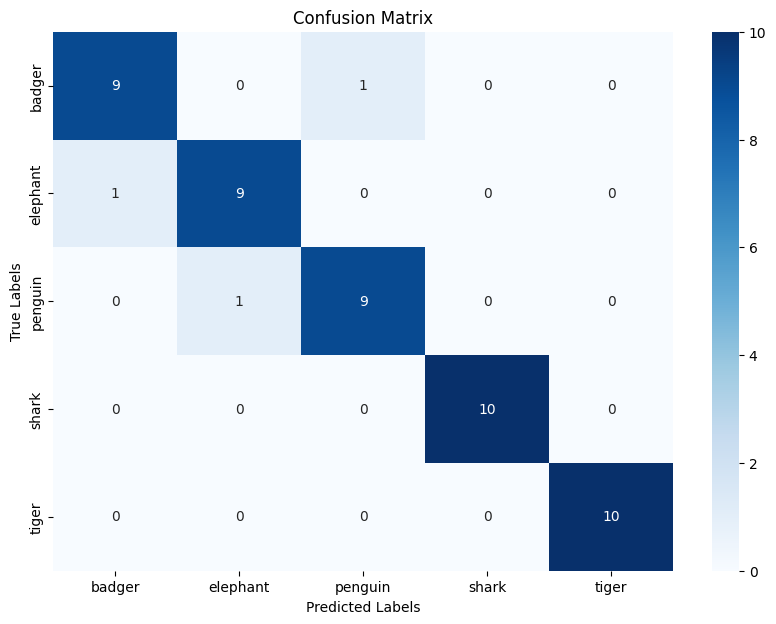

In [17]:
# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []

net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())  # Convert to numpy and add to list
        predicted_labels.extend(predicted.cpu().numpy())  # Convert to numpy and add to list

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
le = preprocessing.LabelEncoder()
le.fit(class_names)

LabelEncoder()

### Result Grid

In [19]:
def visualize_model(model, data_loader, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(25, 30))
    
    fig.canvas.draw()
    
    rows = 5
    columns = 5
    
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])
    
    with torch.no_grad():
            
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            val, preds = torch.max(outputs, 1)

            preds_invtrans = le.inverse_transform(preds.cpu())
            
            labels_invtrans = le.inverse_transform(labels.cpu())
            
            ax = []
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax.append(plt.subplot(rows, columns, images_so_far))

                # Reverse normalize 
                image = inputs.cpu().data[j] * STD[:, None, None] + MEAN[:, None, None]

                image = image.permute(1, 2, 0)

                ax[-1].set_title(f'Ground Truth: {labels_invtrans[j]}\nPredicted: {preds_invtrans[j]}', fontsize=15, fontweight='bold')
                
                # Draw boxes around subplots
                bbox = ax[-1].get_tightbbox(fig.canvas.renderer)
                x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
                
                # slightly increase the very tight bounds:
                xpad = 0.01 * width
                ypad = 0.01 * height
                
                if preds[j] == labels[j]:
                     fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='green', linewidth=5, fill=False))
                else:
                     fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='red', linewidth=5, fill=False))

                plt.imshow(image)
                plt.axis('off')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)
        

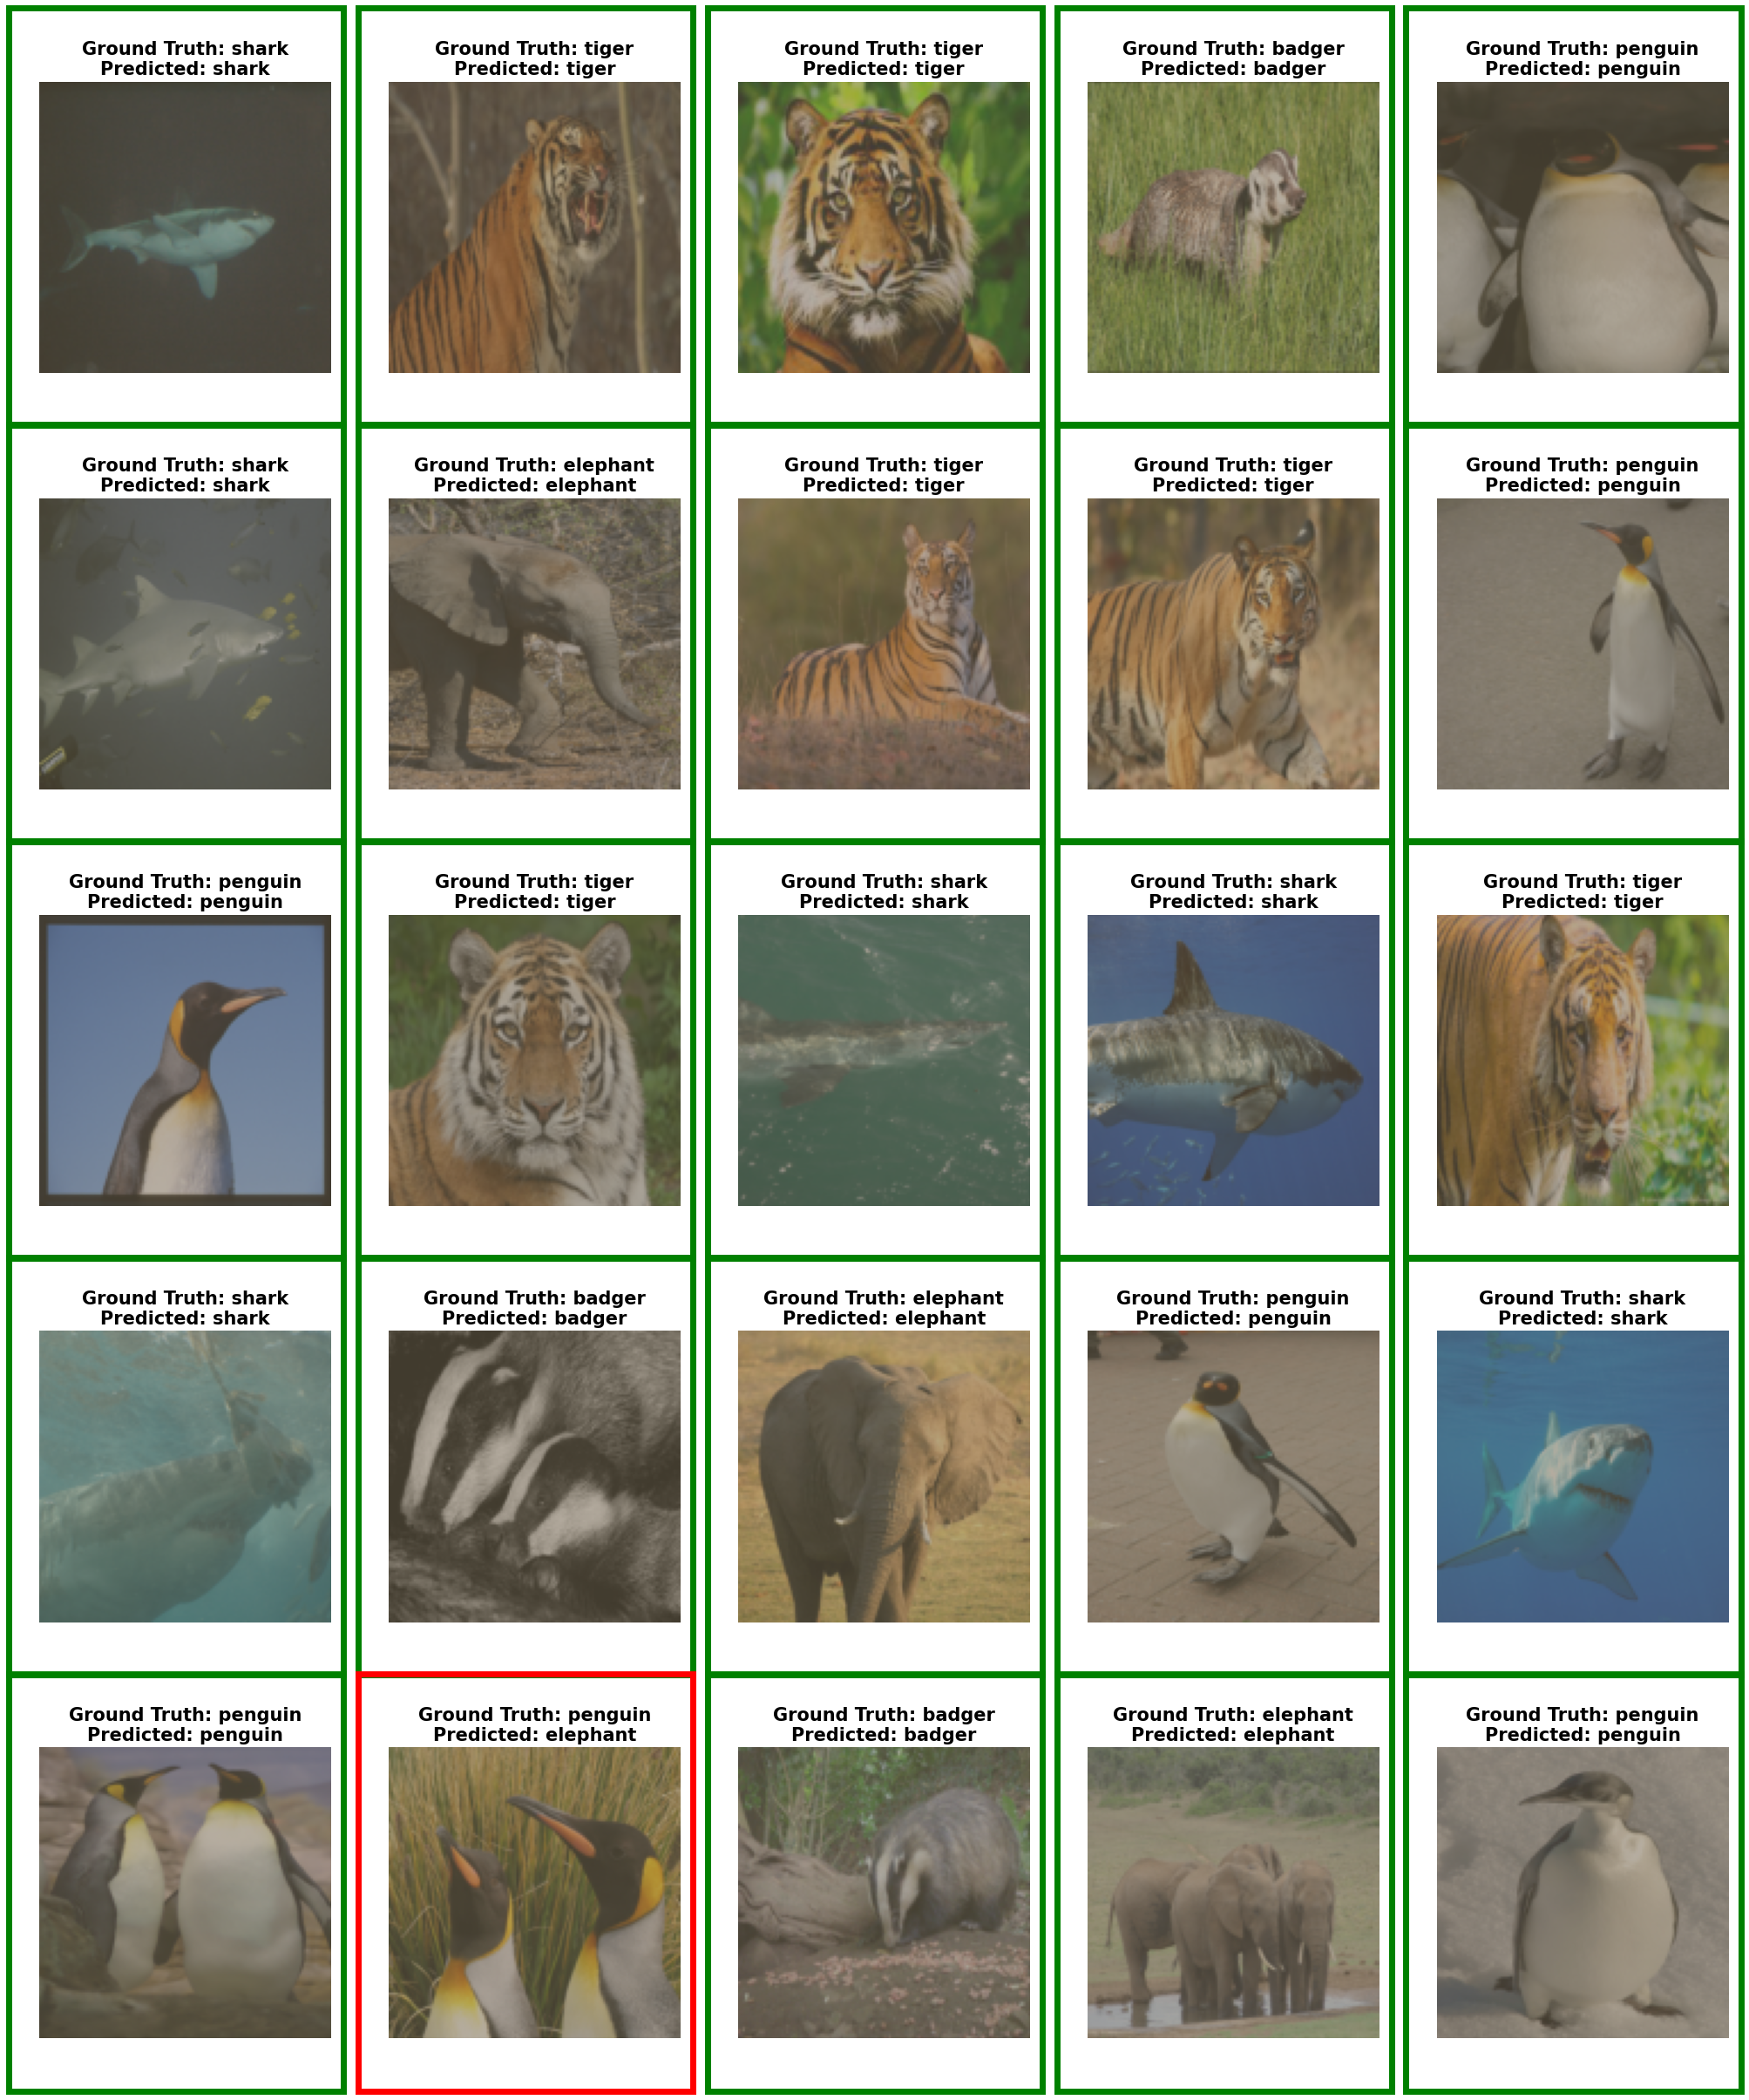

In [20]:
visualize_model(net, test_loader)

### GUI

In [21]:
def predict_with_probs(image_input, model, class_names):
    if image_input is None:
        return "No image provided. Please upload an image or provide a valid URL.", None

    if isinstance(image_input, str):
        if image_input.startswith("http"):
            response = requests.get(image_input)
            img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            img = Image.open(image_input).convert("RGB")
    elif isinstance(image_input, Image.Image):
        img = image_input.convert("RGB")
    else:
        raise ValueError("Unsupported input type. Please provide a valid image or URL.")

    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = transform(img).unsqueeze(0)  # Add batch dimension

    # Move to device
    img = img.to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        logits = model(img)  # Get raw logits
        print("Logits: ", logits)
        probabilities = F.softmax(logits, dim=1)  # Apply softmax

    predicted_class_idx = torch.argmax(probabilities, dim=1).item()
    predicted_class = class_names[predicted_class_idx]
    probs = probabilities.cpu().numpy()[0]  # Convert to numpy array
    probs_text = {class_names[i]: probs[i].item() for i in range(len(class_names))}

    return predicted_class, probs_text


In [32]:
def gradio_interface(image):
    predicted_class, prob_text = predict_with_probs(image, net, class_names)

    if prob_text is None:
        return "No image provided. Please upload an image or provide a valid URL.", None
    
    return predicted_class, prob_text

iface = gr.Interface(
    title="Animal Image Classification",
    description="Accepted Animals: Badger, Elephant, Penguin, Shark, Tiger",
    fn=gradio_interface,
    inputs=gr.Image(type="pil", sources=['upload','clipboard'],label="Upload Image or URL"),
    outputs=[
    gr.Textbox(label="Predicted Class"),
    gr.Label(num_top_classes=5,label="Probability Graph")
    ],
    live=True
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


Logits:  tensor([[-1.9573,  3.8020, -2.4039, -4.6074,  0.9950]], device='cuda:0')
Logits:  tensor([[-1.5085,  0.3287,  6.9647, -1.9730, -4.1320]], device='cuda:0')
Logits:  tensor([[-1.9573,  3.8020, -2.4039, -4.6074,  0.9950]], device='cuda:0')
Logits:  tensor([[-1.2789,  6.0290, -4.0147, -5.2351, -0.8061]], device='cuda:0')
Logits:  tensor([[-1.0529, -2.3974, -3.1897,  5.2130, -0.9263]], device='cuda:0')
Logits:  tensor([[ 8.8645, -0.8148, -4.3736, -6.1806, -2.2113]], device='cuda:0')
Logits:  tensor([[-1.0529, -2.3974, -3.1897,  5.2130, -0.9263]], device='cuda:0')
Logits:  tensor([[ 8.8645, -0.8148, -4.3736, -6.1806, -2.2113]], device='cuda:0')
